# Swiss Roll Embedding in 2D

In this document we test the benefits of using multi-time-steps Markov transition matrix as inputs to the KL divergence optimization solved by t-SNE. When constructing a proximity matrix for t-SNE, one might consider keeping bandwidths small for the Gaussian kernel, but then taking higher powers, $P^t$, of the corresponding conditional probability matrix, $P = P_{j|i}$. Varying powers of $P$ allow for studing the geometry of the data at different scales.

## 0. Setup


In [1]:
import sys
import os
#limit the number of threds numpy/scipy are using
os.environ["OMP_NUM_THREADS"] = "4"
nthreads = 4

import time 
import pickle
import numpy as np
import multiprocessing as mp

# Custom pyscripts
maindir = '/home/lanhuong/Projects/ManifoldLearning/DiffusionTSNE'
curdir = os.getcwd()
#maindir = '../'
os.chdir(maindir)

from diffusion_tsne import diffusion_tsne

from plotting import *
from generate_data import *
from utils import *
from metrics import *

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.titlesize'] = 30
mpl.rcParams['axes.titlesize']   = 30
mpl.rcParams['axes.labelsize']   = 20
mpl.rcParams['xtick.labelsize']  = 16
mpl.rcParams['ytick.labelsize']  = 16
mpl.rc('text', usetex=True)

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [20]:
#np.show_config()

## 1. Swiss Roll uniformly sampled

In [3]:
# uniformly sampled
np.random.seed(123)
n_points = 3000; noise = 0.5
X, color, y = swiss_roll(n_points, noise)
GX = distance2(np.vstack((color, y)).T)
X.shape
Xtruth = np.array([color, y]).T
Xtruth.shape

(3000, 2)

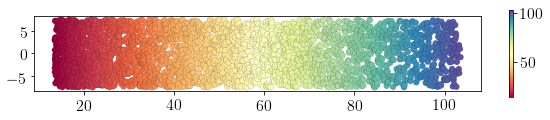

In [8]:
p0 = plot2D(np.vstack((color, y)).T, label=color, figsize=(10, 2))
plt.axes().set_aspect(1.0)

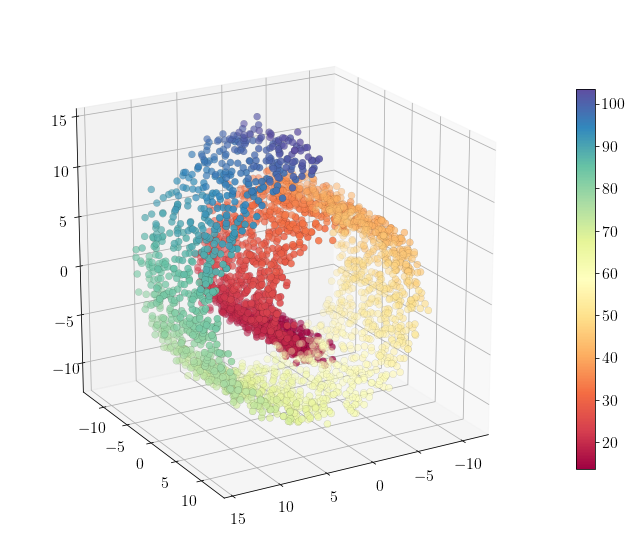

In [4]:
p = plot3D(X, label=color)

# 1.0 PCA

In [6]:
import sklearn.decomposition # PCA
start = time.time()
pca_operator = sklearn.decomposition.PCA(n_components=2)
Y_pca = pca_operator.fit_transform(X)
end = time.time()
print("Embedded PCA in {:.2f} seconds.".format(end-start))
Y_pca.shape

Embedded PCA in 0.11 seconds.


(3000, 2)

/home/lanhuong/.local/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


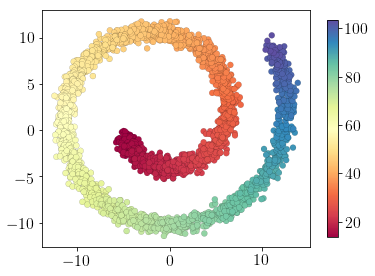

In [7]:
plot2D(Y_pca, label = color,figsize=(6, 5))
plt.axes().set_aspect(1.0)

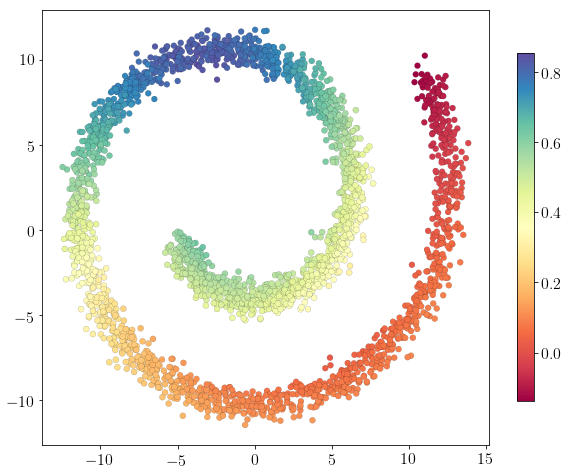

In [9]:
score_pca = coranking_quality(X, Y_pca, 'QNK', 1, 250)
rho_pca = geo_rho(X, Y_pca, GX = GX)
plot2D(Y_pca, label = rho_pca,figsize=(10, 8))

In [10]:
print(np.mean(rho_pca))
print(np.var(rho_pca))

0.4103112096316158
0.06899196101617854


## 1.1 PHATE

In [11]:
import phate
start = time.time()
phate_operator = phate.PHATE(n_jobs=-2)
Y_phate = phate_operator.fit_transform(X)
end = time.time()
print("Embedded with PHATE in {:.2f} seconds.".format(end-start))

Calculating PHATE...
  Running PHATE on 3000 cells and 3 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.10 seconds.
  Calculated graph and diffusion operator in 0.49 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.34 seconds.
    Calculating KMeans...
    Calculated KMeans in 20.44 seconds.
  Calculated landmark operator in 22.21 seconds.
  Calculating optimal t...
    Automatically selected t = 42
  Calculated optimal t in 3.15 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.18 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 20.55 seconds.
Calculated PHATE in 47.58 seconds.
Embedded with PHATE in 47.59 seconds.


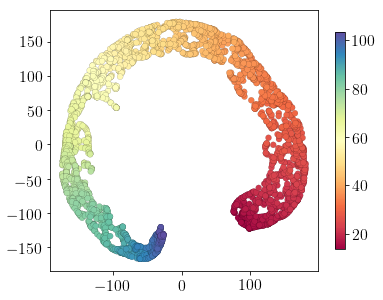

In [22]:
plot2D(Y_phate, label = color,figsize=(6, 5))
plt.axes().set_aspect(1.0)

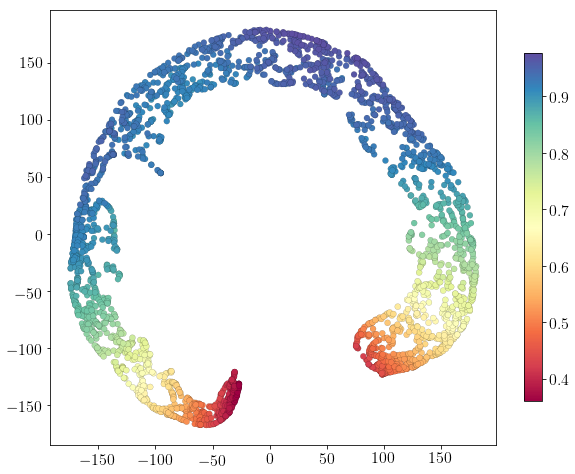

In [21]:
score_phate = coranking_quality(X, Y_phate, 'QNK', 1, 250)
rho_phate = geo_rho(X, Y_phate, GX = GX)
plot2D(Y_phate, label = rho_phate,figsize=(10, 8))
plt.axes().set_aspect(1.0)

In [14]:
print(np.mean(rho_phate))
print(np.var(rho_phate))

0.7771986691014816
0.03425994101993983


## 1.2 Isomap

In [15]:
from sklearn.manifold import Isomap
n_neighbors = 12
n_components = 2
t0 = time.time()
Y_iso = Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time.time()
print("Isomap: %.2g sec" % (t1 - t0))

Isomap: 4.7 sec


/home/lanhuong/.local/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


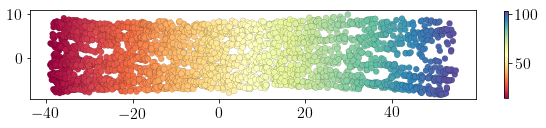

In [16]:
plot2D(Y_iso, label = color, figsize=(10, 2))
plt.axes().set_aspect(1.0)

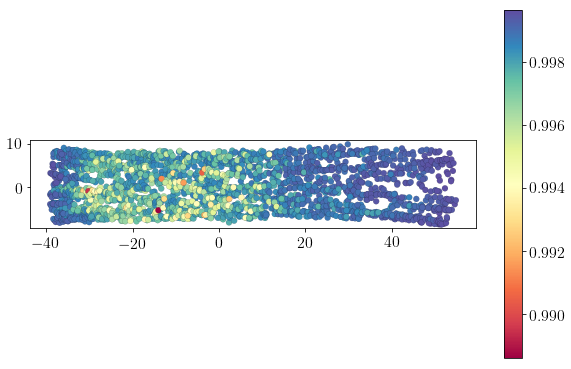

In [20]:
#GX = pairwise_distances(np.vstack((color, y)).T)
#GX = pairwise_distances(y.reshape((X.shape[0], 1)))
#Y_iso0 = Y_iso[:, 1].reshape((X.shape[0], 1))
rho_iso = geo_rho(X, Y_iso, GX = GX)
plot2D(Y_iso, label = rho_iso, figsize=(10, 8))
plt.axes().set_aspect(1.0)

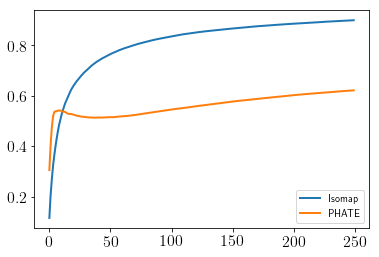

In [23]:
score_iso = coranking_quality(Xtruth, Y_iso, "QNK", 1, 250)

fig, ax = plt.subplots()
line1, = ax.plot(range(len(score_iso)), score_iso, 
                 linewidth=2,label='Isomap')
line1, = ax.plot(range(len(score_iso)), score_phate, 
                 linewidth=2,label='PHATE')
ax.legend(loc='lower right')
plt.show()

In [24]:
print(np.mean(rho_phate))
np.mean(rho_iso)

0.7771986691014816


0.9981122838188462

## 1.3 Standard t-SNE

t-SNE embedding in 16.715766 sec


(-90.83181289823251, 64.79601959378917, -66.4870130625155, 53.76869412330652)

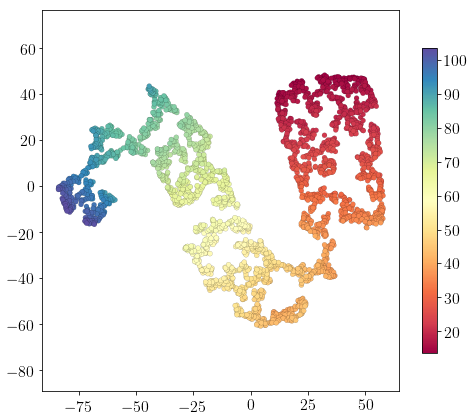

In [26]:
from sklearn.manifold import TSNE
start = time.time()
Y_tsne_perp30 = TSNE(n_components=2, perplexity=30).fit_transform(X)
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y_tsne_perp30, label=color, s=25, figsize=(8,7))
plt.axis('equal')

t-SNE embedding in 48.203698 sec


(-16.517634526803075,
 16.997019902779638,
 -17.64555397895838,
 15.288845452347049)

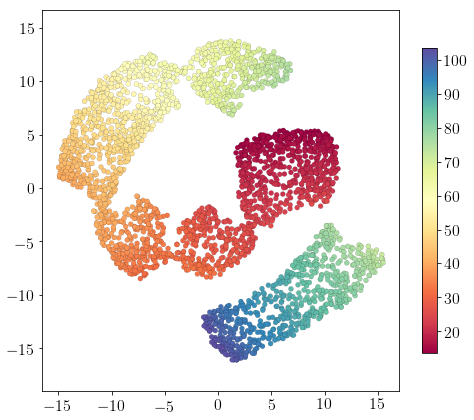

In [27]:
from sklearn.manifold import TSNE
start = time.time()
Y_tsne_perp300 = TSNE(n_components=2, perplexity=300).fit_transform(X)
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y_tsne_perp300, label=color, s=25, figsize=(8,7))
plt.axis('equal')

## 1.4 Diffusion t-SNE

Diffusion t-SNE embedding in 48.465027 sec


(-35.15367141930356, 40.11626642154767, -10.746013334535187, 6.717011608362423)

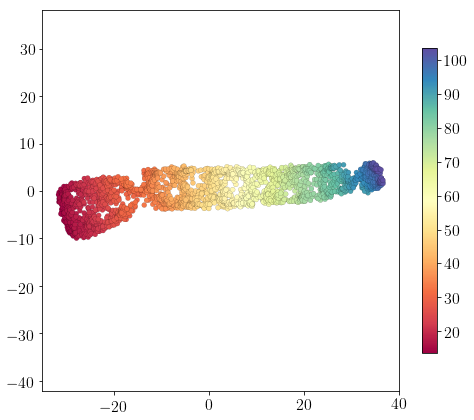

In [105]:
start = time.time()
Y_difftsne_p25t10 = diffusion_tsne(
    X, perplexity=30, time_steps=10,
    seed=12345, nthreads=nthreads,
    load_affinities="save", save_files=True, affinities_dir = "examples/SwissRoll-noisy/"
)
end = time.time()
print('Diffusion t-SNE embedding in %f sec' %(end-start))
plot2D(Y_difftsne_p25t10, label=color, s=25, figsize=(8,7))
plt.axis('equal')

Diffusion t-SNE embedding in 50.092173 sec


(-19.034515732639594,
 20.491772102159505,
 -5.432285624760842,
 5.454468226336098)

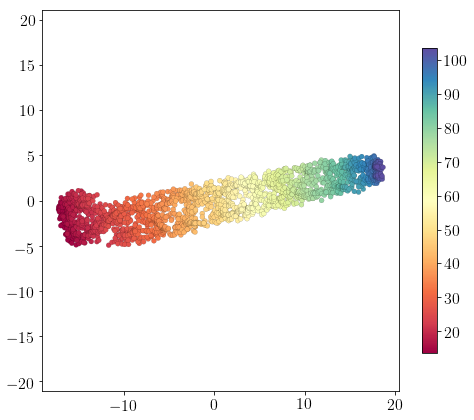

In [106]:
start = time.time()
start = time.time()
Y_difftsne_p25t10 = diffusion_tsne(
    X, perplexity=30, time_steps=30, seed=475, nthreads=nthreads,
    load_affinities="save", save_files=True, affinities_dir = "examples/SwissRoll-noisy/"
)
end = time.time()
print('Diffusion t-SNE embedding in %f sec' %(end-start))
plot2D(Y_difftsne_p25t10, label=color, s=25, figsize=(8,7))
plt.axis('equal')

## 1.5 Scaled Diffusion t-SNE

Diffusion t-SNE embedding in 49.767169 sec


(-26.847778437102278, 20.88394916478693, -9.19785559347503, 11.668687777591012)

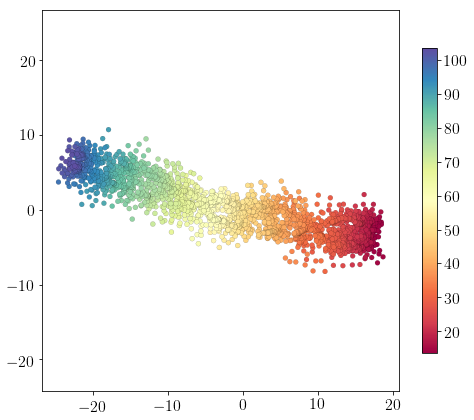

In [107]:
start = time.time()
Y_difftsne_scale = diffusion_tsne(
    X, perplexity=30, time_steps=30,
    seed=1, nthreads=nthreads, scale_probs = True,
     load_affinities="save", 
    save_files=True, affinities_dir = "examples/SwissRoll-noisy/"
)
end = time.time()
print('Diffusion t-SNE embedding in %f sec' %(end-start))
plot2D(Y_difftsne_scale, label=color, s=25, figsize=(8,7))
plt.axis('equal')

In [31]:
os.getcwd()

'/home/lanhuong/Projects/ManifoldLearning/DiffusionTSNE'

# 2. Performance evaluation

## 2.1 Standard t-SNE

In [32]:
np.log( [10, 25, 50, 100, 250, 500])

array([2.30258509, 3.21887582, 3.91202301, 4.60517019, 5.52146092,
       6.2146081 ])

In [33]:
def standard_tsne(X, perp, nthreads, seed):
    it_dir = 'examples/SwissRoll-noisy/standard_tsne/affinities_perp'+ \
        str(perp) + '_it' + str(seed) + "/"
    start = time.time()
    Y = diffusion_tsne(
        X, perplexity=perp, seed=seed, nthreads=nthreads, 
        load_affinities="save", save_files=True, affinities_dir = it_dir)
    end = time.time()
    res = {'embedding' : Y, 'time' : end - start, 'seed' : seed, 
           'perp' : perp, 'method' : 'standard_tsne'}
    return res

results = {}
ncopies = 5
perps  = [10, 25, 50, 100, 250, 300, 500]
NCORES = 40
pool = mp.Pool(processes = min(len(perps)*ncopies*nthreads, NCORES, mp.cpu_count()))
for perp in perps:
    print('Perplexity: %d' %(perp))
    for i in range(ncopies):
        seed = np.random.randint(1, 1e5, size = 1)[0]
        trial = 'perp' + str(perp) + '_it' + str(i)
        results[trial] = pool.apply_async(standard_tsne, args = (X, perp, nthreads, seed))
pool.close()
pool.join()
vanilla_tsne_res = {name : result.get() for name, result in results.items()}

filename = 'examples/SwissRoll-noisy/standard_tsne/embeddings.pkl'
with open(filename, 'wb') as handle:
    pickle.dump(vanilla_tsne_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

Making directory examples/SwissRoll-noisy/standard_tsne/affinities_perp10_it6478/
Making directory examples/SwissRoll-noisy/standard_tsne/affinities_perp10_it52770/
Making directory examples/SwissRoll-noisy/standard_tsne/affinities_perp25_it89011/
Making directory examples/SwissRoll-noisy/standard_tsne/affinities_perp10_it49504/
Making directory examples/SwissRoll-noisy/standard_tsne/affinities_perp25_it37562/
Making directory examples/SwissRoll-noisy/standard_tsne/affinities_perp25_it5644/
Making directory examples/SwissRoll-noisy/standard_tsne/affinities_perp25_it88073/
Making directory examples/SwissRoll-noisy/standard_tsne/affinities_perp10_it98771/
Making directory examples/SwissRoll-noisy/standard_tsne/affinities_perp50_it22038/
Making directory examples/SwissRoll-noisy/standard_tsne/affinities_perp10_it51716/
Making directory examples/SwissRoll-noisy/standard_tsne/affinities_perp25_it18994/
Making directory examples/SwissRoll-noisy/standard_tsne/affinities_perp50_it68512/
Making

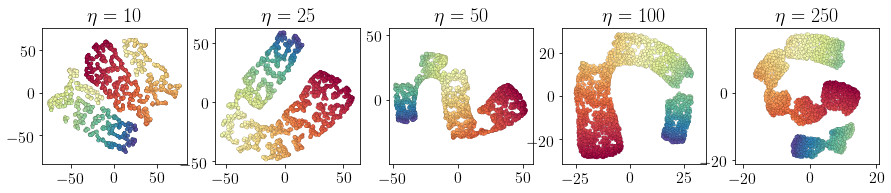

In [35]:
perps  = [10, 25, 50, 100, 250]
embds = [vanilla_tsne_res['perp' + str(perp) + '_it2']['embedding'] for perp in perps]
names = [r"$\eta = %d$" %perp for perp in perps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(15, 2.5), 
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

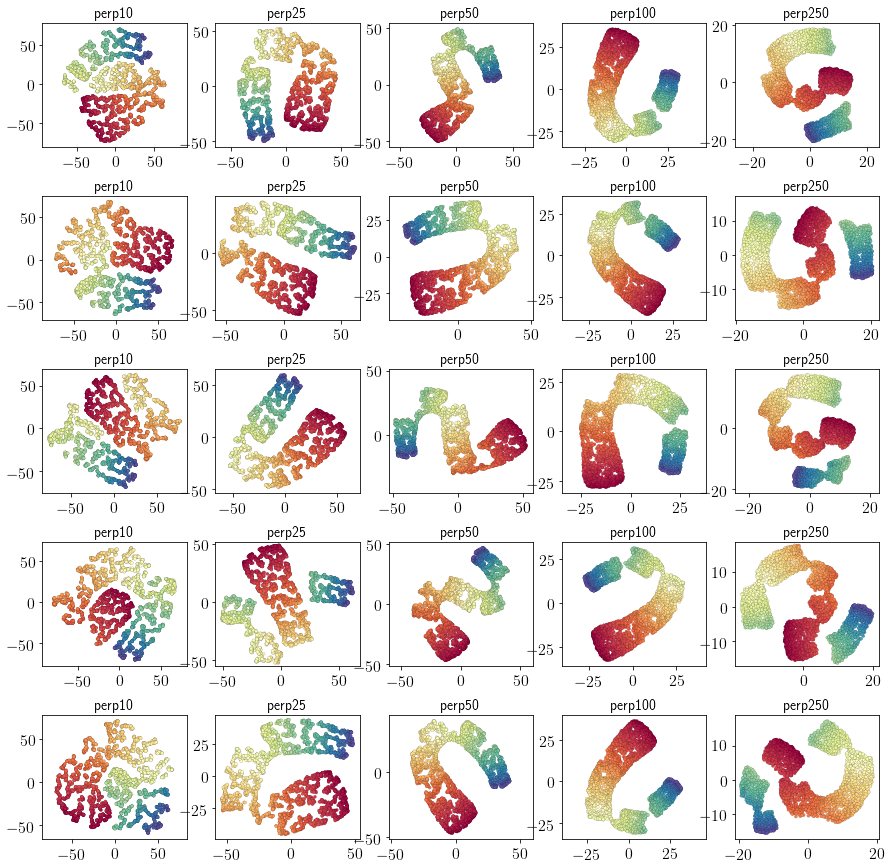

In [36]:
perps  = [10, 25, 50, 100, 250]
vanilla_tsne_embd, vanilla_tsne_time = get_res(
    vanilla_tsne_res, color, perps, figsize = (15, 15))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

In [37]:
perps  = [10, 25, 50, 100, 250, 300, 500]
vanilla_tsne_spearman_mean = {}
vanilla_tsne_spearman_var = {}

keys = list(vanilla_tsne_embd.keys())
for perp in perps:
    cur_keys = [key for key in keys if 'perp' + str(perp) + '_' in key]
    pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
    results = {}
    for key in cur_keys:
        Y = vanilla_tsne_embd[key]
        results[key] = pool.apply_async(geo_rho, args = (X, Y, GX))
    pool.close()
    pool.join()
    rho_mean_lst = [np.mean(res.get()) for name, res in results.items()]  # over data points
    rho_var_lst = [np.var(res.get()) for name, res in results.items()]
    vanilla_tsne_spearman_mean['perp' + str(perp)] = rho_mean_lst
    vanilla_tsne_spearman_var['perp' + str(perp)] = rho_var_lst

In [38]:
# import pickle
# filename = 'examples/SwissRoll-noisy/standard_tsne/swiss_roll_vanilla_tsne.pkl'
# outfile = open(filename,'wb')
# obj_dict = {'X': X, 'color':color, 'y': y,
#             'vanilla_tsne_res':vanilla_tsne_res, 
#             'vanilla_tsne_spearman_mean':vanilla_tsne_spearman_mean,
#             'vanilla_tsne_spearman_var':vanilla_tsne_spearman_var
#            }
# pickle.dump(obj_dict, outfile)
# outfile.close()

In [ ]:
import pickle
filename = 'examples/SwissRoll-noisy/standard_tsne/swiss_roll_vanilla_tsne.pkl'
infile = open(filename,'rb')
new_dict = pickle.load(infile) 
infile.close()
locals().update(new_dict)

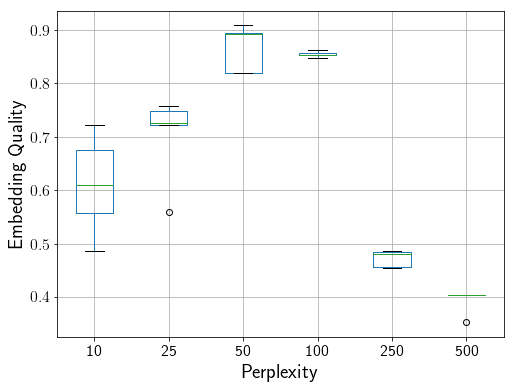

In [39]:
import pandas as pd
perps  = [10, 25, 50, 100, 250, 500]
df = pd.DataFrame(vanilla_tsne_spearman_mean, 
                  columns = ['perp' + str(perp) for perp in perps])
df.columns = [str(perp) for perp in perps]
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Perplexity")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 20})

In [40]:
print(df.mean())
print(np.sqrt(df.var()))

10     0.609796
25     0.702656
50     0.866198
100    0.853985
250    0.472116
500    0.393831
dtype: float64
10     0.092921
25     0.082039
50     0.043788
100    0.005489
250    0.015317
500    0.022623
dtype: float64


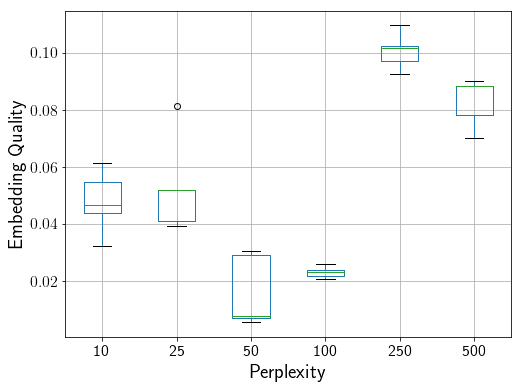

In [41]:
perps  = [10, 25, 50, 100, 250, 500]
dfvar = pd.DataFrame(vanilla_tsne_spearman_var, 
                  columns = ['perp' + str(perp) for perp in perps])
dfvar.columns = [str(perp) for perp in perps]
plt.figure(figsize=(8, 6))
dfvar.boxplot()
plt.xlabel("Perplexity")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 20})

In [45]:
vanilla_tsne_corank.keys()

dict_keys(['perp10', 'perp25', 'perp50', 'perp100', 'perp250', 'perp300', 'perp500'])

In [44]:
# Coranking matrix
perps  = [10, 25, 50, 100, 250, 300, 500]
vanilla_tsne_corank = {}   
keys = list(vanilla_tsne_embd.keys())
for perp in perps:
    cur_keys = [key for key in keys if 'perp' + str(perp) + '_' in key]
    pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
    results = {}
    for key in cur_keys:
        Y = vanilla_tsne_embd[key]
        results[key] = pool.apply_async(coranking_quality, args = (Xtruth, Y, 'QNK', 1, 250))
    pool.close()
    pool.join()
    crank = { name: res.get() for name, res in results.items()}
    vanilla_tsne_corank['perp' + str(perp)] = crank

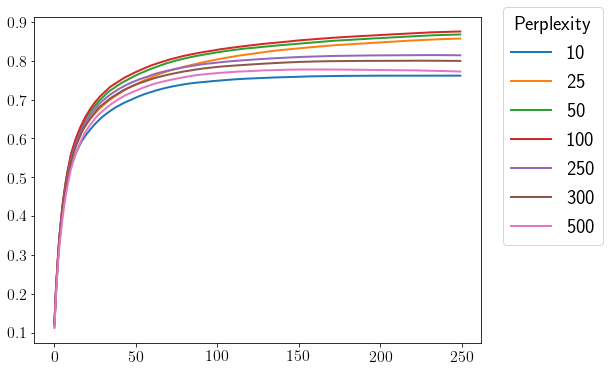

In [46]:
fig, ax = plt.subplots(figsize = (8, 6))
for perp in perps:
    pname = 'perp' + str(perp) 
    perp_corank = vanilla_tsne_corank[pname]
    perp_corank = [ val for k, val in perp_corank.items()]
    perp_corank = np.array(perp_corank)
    mean_perp_corank = np.mean(perp_corank, axis = 0).ravel()
    n = mean_perp_corank.shape[0]
    line, = ax.plot(range(n), mean_perp_corank, linewidth=2, label=str(perp))
ax.legend(loc=(250, 0), title='Perplexity', bbox_to_anchor= (1.05, 0.3))
plt.show()

In [47]:
import pickle
filename = 'examples/SwissRoll-noisy/standard_tsne/swiss_roll_vanilla_tsne.pkl'
outfile = open(filename,'wb')
obj_dict = {'X': X, 'color':color, 'y': y,
            'vanilla_tsne_res':vanilla_tsne_res, 
            'vanilla_tsne_spearman_mean':vanilla_tsne_spearman_mean,
            'vanilla_tsne_spearman_var':vanilla_tsne_spearman_var,
            'vanilla_tsne_corank':vanilla_tsne_corank
           }
pickle.dump(obj_dict, outfile)
outfile.close()

## 2.2. Diffusion t-SNE

In [48]:
def difftsne(X, perp, tstep, nthreads, seed):
    it_dir = 'examples/SwissRoll-noisy/diffusion_tsne/affinities_perp'+\
        str(perp) + '_tstep' + str(tstep) + '_it' + str(seed) + "/"
    start = time.time()
    Y = diffusion_tsne(
        X, seed=seed, time_steps = tstep, perplexity = perp,
        scale_probs = False, nthreads=nthreads, 
        load_affinities="save", save_files=True, affinities_dir = it_dir)
    end = time.time()
    res = {'embedding' : Y, 'perp' : perp, 'tstep': tstep, 
           'method' : 'diffusion_fitsne', 'seed' : seed,
           'time' : end - start}
    return res

ncopies = 5; NCORES = 40
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50, 100]
nComb = len(tsteps) * ncopies 
difftsne_res_dict = {}
for perp in perps:
    pool = mp.Pool(processes = min(nComb, int(NCORES/nthreads), int(mp.cpu_count()/nthreads)))
    results = {}
    for tstep in tsteps: 
        print('Perplexity: %d, t-step %d' %(perp, tstep))
        for i in range(ncopies):
            seed = np.random.randint(1, 1e5, size = 1)[0]
            trial = 'perp' + str(perp) + '_tstep' + str(tstep) +'_it' + str(i)
            try:
                results[trial] = pool.apply_async(
                    difftsne, args = (X, perp, tstep, nthreads, seed))
            except:
                results[trial] = {'embedding' : -1, 'time': -1}
    pool.close()
    pool.join()
    res = {name : result.get() for name, result in results.items()}
    difftsne_res_dict['perp' + str(perp)] = res
difftsne_res = difftsne_res_dict['perp' + str(perps[0])]
for i in range(1, len(perps)):
    difftsne_res.update(difftsne_res_dict['perp' + str(perps[i])])

Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp10_tstep1_it78571/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp10_tstep1_it58605/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp10_tstep1_it85971/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp10_tstep1_it41656/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp10_tstep1_it33958/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp10_tstep5_it56792/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp10_tstep5_it15877/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp10_tstep5_it66474/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp10_tstep5_it50477/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp10_tstep5_it92774/
Perplexity: 10, t-step 1
Perplexity: 10, t-step 5
Perplexity: 10, t-step 10
Perplexity: 10

Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp25_tstep100_it51100/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp25_tstep100_it9697/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp25_tstep100_it4739/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp25_tstep100_it22539/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp25_tstep100_it49829/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp30_tstep1_it14287/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp30_tstep1_it90249/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp30_tstep1_it54314/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp30_tstep1_it1806/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp30_tstep1_it68350/
Making directory examples/SwissRoll-noisy/diffusion_tsne/affinities_perp30_tstep5_i

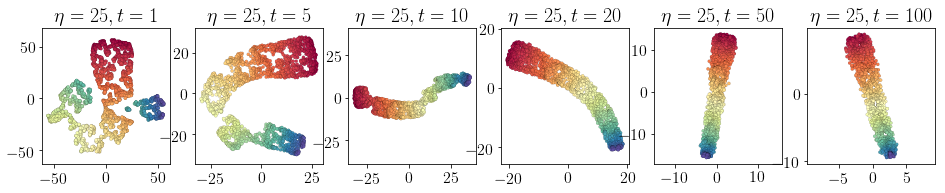

In [108]:
tsteps  = [1, 5, 10, 20, 50, 100]
embds = [difftsne_res['perp25_tstep' + str(tstep) + '_it0']['embedding'] for tstep in tsteps]
names = [r"$\eta = 25, t = %d$" %tstep for tstep in tsteps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(16, 2.5), ncol = 6,
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

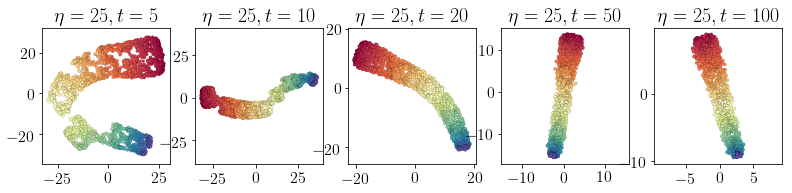

In [49]:
tsteps  = [5, 10, 20, 50, 100]
embds = [difftsne_res['perp25_tstep' + str(tstep) + '_it0']['embedding'] for tstep in tsteps]
names = [r"$\eta = 25, t = %d$" %tstep for tstep in tsteps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(16, 2.5), ncol = 6,
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

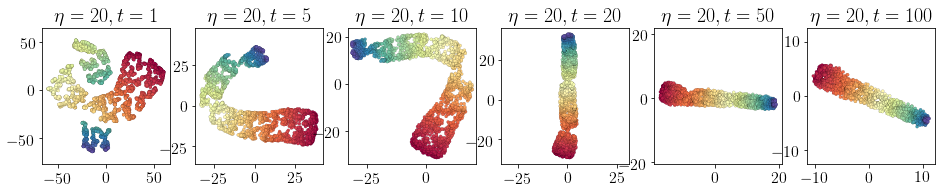

In [110]:
tsteps  = [1, 5, 10, 20, 50, 100]
embds = [difftsne_res['perp20_tstep' + str(tstep) + '_it0']['embedding'] for tstep in tsteps]
names = [r"$\eta = 20, t = %d$" %tstep for tstep in tsteps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(16, 2.5), ncol = 6,
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

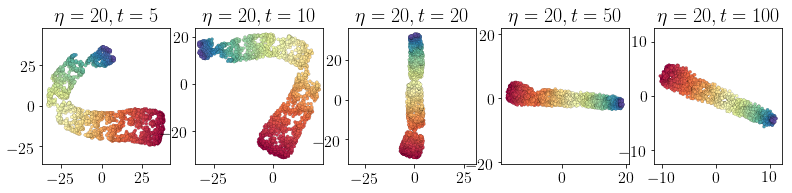

In [109]:
tsteps  = [ 5, 10, 20, 50, 100]
embds = [difftsne_res['perp20_tstep' + str(tstep) + '_it0']['embedding'] for tstep in tsteps]
names = [r"$\eta = 20, t = %d$" %tstep for tstep in tsteps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(16, 2.5), ncol = 6,
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

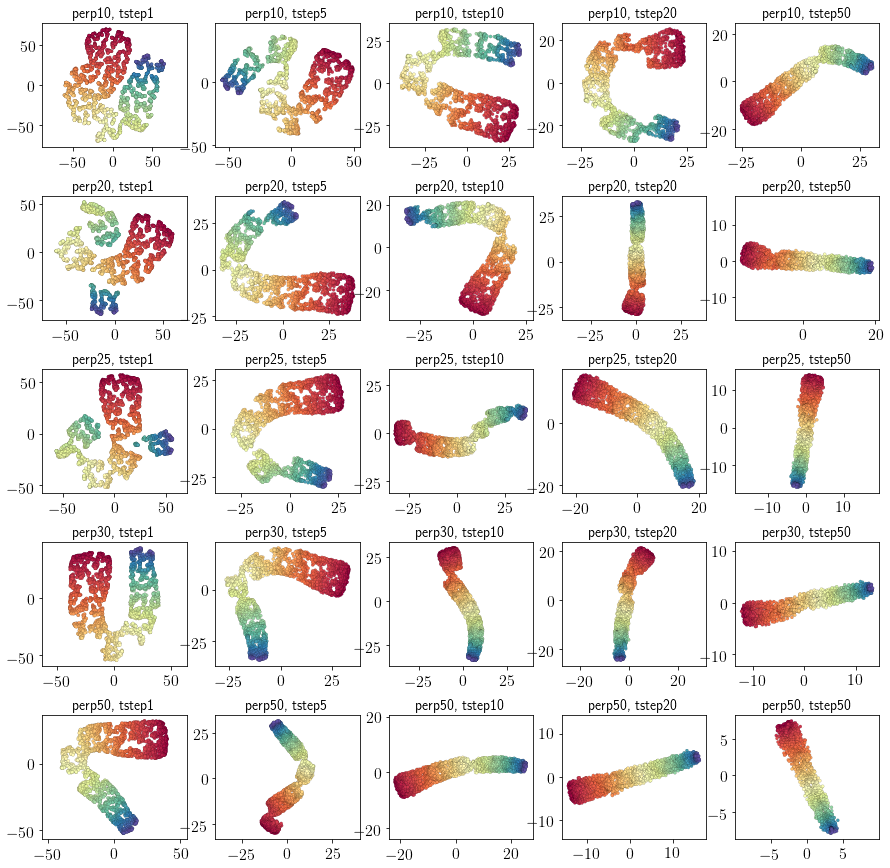

In [51]:
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50]
difftsne_embd, difftsne_time = get_res(
    difftsne_res, color, perps, 
    tsteps, figsize = (15, 15))
plt.subplots_adjust(hspace=0.4, wspace = 0.2)

In [52]:
# Performance
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50, 100]
keys = list(difftsne_embd.keys())
diff_tsne_spearman_mean = {}
diff_tsne_spearman_var = {}

keys = list(difftsne_embd.keys())
for perp in perps:
    for tstep in tsteps:
        comb = 'perp' + str(perp) + '_' + 'tstep' + str(tstep) + "_"
        cur_keys = [key for key in keys if comb in key]
        pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
        results = {}
        for key in cur_keys:
            Y = difftsne_embd[key]
            results[key] = pool.apply_async(geo_rho, args = (X, Y, GX))
        pool.close()
        pool.join()
        rho_mean_lst = [np.mean(res.get()) for name, res in results.items()]  # over data points
        rho_var_lst = [np.var(res.get()) for name, res in results.items()]
        diff_tsne_spearman_mean[comb] = rho_mean_lst
        diff_tsne_spearman_var[comb] = rho_var_lst

In [53]:
# Coranking matrix
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50, 100]
diff_tsne_corank = {}   
keys = list(difftsne_embd.keys())
for perp in perps:
    for tstep in tsteps:
        comb = 'perp' + str(perp) + '_' + 'tstep' + str(tstep) + "_"
        cur_keys = [key for key in keys if comb in key]
        pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
        results = {}
        for key in cur_keys:
            Y = difftsne_embd[key]
            results[key] = pool.apply_async(coranking_quality, args = (Xtruth, Y, 'QNK', 1, 250))
        pool.close()
        pool.join()
        crank = { name: res.get() for name, res in results.items()}
        diff_tsne_corank[comb] = crank

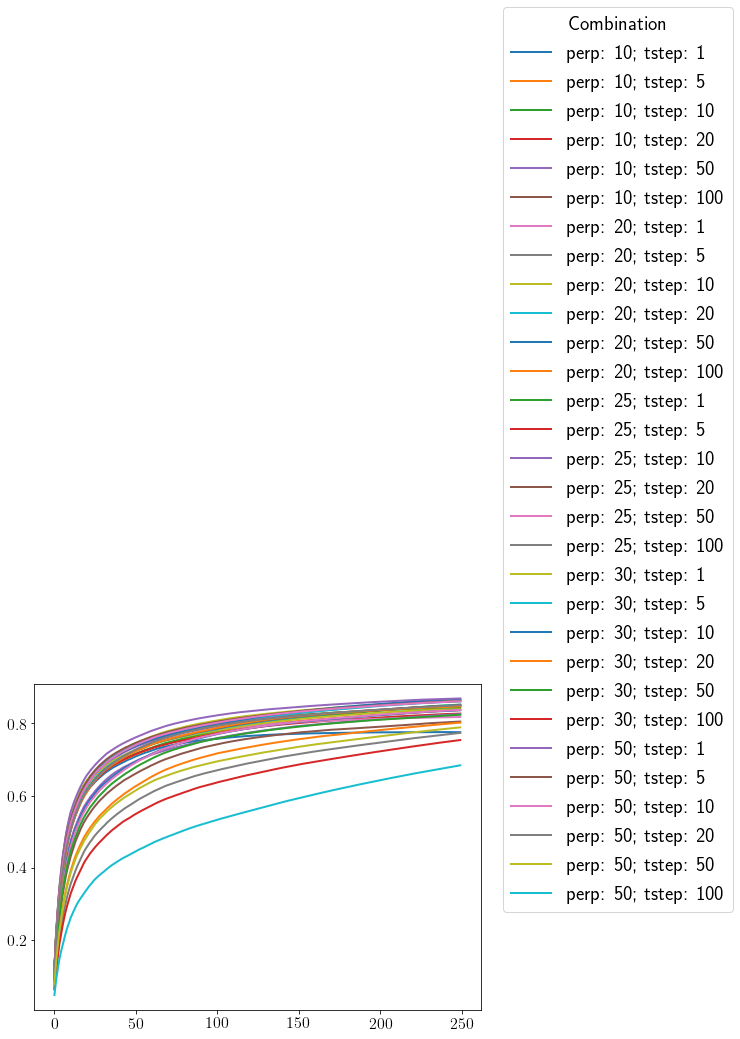

In [54]:
fig, ax = plt.subplots(figsize = (8, 6))
for perp in perps:
    for tstep in tsteps:
        comb = 'perp' + str(perp) + '_' + 'tstep' + str(tstep) + "_"
        comb_corank = diff_tsne_corank[comb]
        comb_corank = [ val for k, val in comb_corank.items()]
        comb_corank = np.array(comb_corank)
        mean_comb_corank = np.mean(comb_corank, axis = 0).ravel()
        n = mean_comb_corank.shape[0]
        line, = ax.plot(range(n), mean_comb_corank, linewidth=2, 
                        label= 'perp: ' + str(perp) + '; ' + 'tstep: ' + str(tstep))
ax.legend(loc=(250, 0), title='Combination', bbox_to_anchor= (1.05, 0.3))
plt.show()

In [55]:
# import pickle
# filename = 'examples/SwissRoll-noisy/diffusion_tsne/swiss_roll_diff_tsne.pkl'
# outfile = open(filename,'wb')
# obj_dict = {'X': X, 'color':color, 'y': y,
#             'difftsne_res':difftsne_res, 
#             'diff_tsne_spearman_mean':diff_tsne_spearman_mean,
#             'diff_tsne_spearman_var':diff_tsne_spearman_var,
#             'diff_tsne_corank':diff_tsne_corank
#            }
# pickle.dump(obj_dict, outfile)
# outfile.close()

In [140]:
import pickle
filename = 'examples/SwissRoll-noisy/diffusion_tsne/swiss_roll_diff_tsne.pkl'
infile = open(filename,'rb')
new_dict = pickle.load(infile) 
infile.close()
locals().update(new_dict)

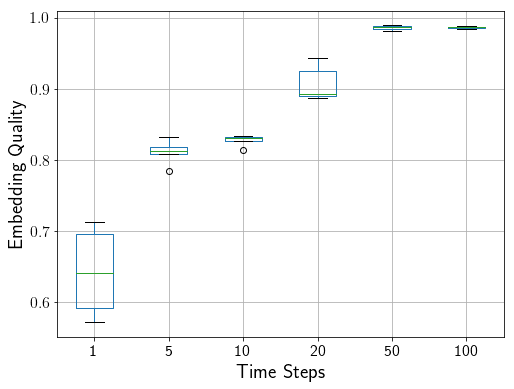

In [56]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp10_' in key]
df = pd.DataFrame(diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 20})

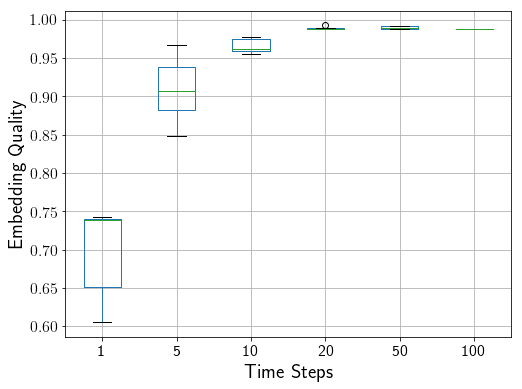

In [57]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp20_' in key]
df = pd.DataFrame(diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 20})

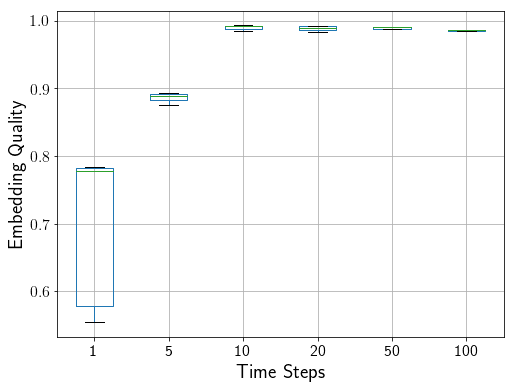

In [58]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp25_' in key]
df = pd.DataFrame(diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

In [59]:
print(df.mean())
print(np.sqrt(df.var()))

1      0.694944
5      0.886656
10     0.990273
20     0.989109
50     0.989819
100    0.985668
dtype: float64
1      0.117983
5      0.007264
10     0.003555
20     0.004058
50     0.001357
100    0.000933
dtype: float64


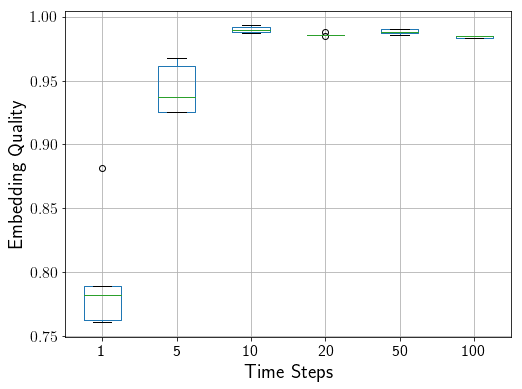

In [60]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp30_' in key]
df = pd.DataFrame(diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

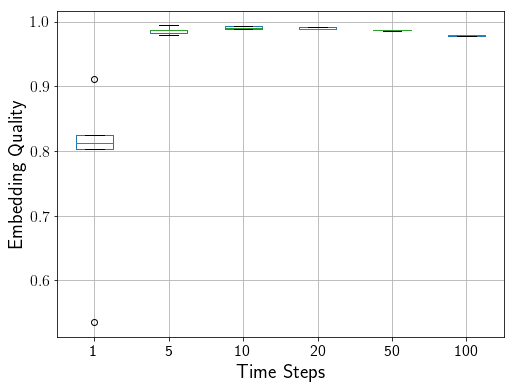

In [61]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp50_' in key]
df = pd.DataFrame(diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

## 2.3 Scaled Diffusion t-SNE

In [62]:
def scaled_difftsne(X, perp, tstep, nthreads, seed):
    it_dir = 'examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp'+\
        str(perp) + '_tstep' + str(tstep) + '_it' + str(seed) + "/"
    start = time.time()
    Y = diffusion_tsne(
        X, seed=seed, time_steps = tstep, perplexity = perp,
        scale_probs = True, nthreads=nthreads, 
        load_affinities="save", save_files=True, affinities_dir = it_dir)
    end = time.time()
    res = {'embedding' : Y, 'perp' : perp, 'tstep': tstep, 
           'method' : 'diffusion_fitsne', 'seed' : seed,
           'time' : end - start}
    return res

ncopies = 5; NCORES = 40
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50, 100]
nComb = len(tsteps) * ncopies 
scaled_difftsne_res_dict = {}
for perp in perps:
    pool = mp.Pool(processes = min(nComb, int(NCORES/nthreads), int(mp.cpu_count()/nthreads)))
    results = {}
    for tstep in tsteps: 
        print('Perplexity: %d, t-step %d' %(perp, tstep))
        for i in range(ncopies):
            seed = np.random.randint(1, 1e5, size = 1)[0]
            trial = 'perp' + str(perp) + '_tstep' + str(tstep) +'_it' + str(i)
            try:
                results[trial] = pool.apply_async(
                    scaled_difftsne, args = (X, perp, tstep, nthreads, seed))
            except:
                results[trial] = {'embedding' : -1, 'time': -1}
    pool.close()
    pool.join()
    res = {name : result.get() for name, result in results.items()}
    scaled_difftsne_res_dict['perp' + str(perp)] = res
scaled_difftsne_res = scaled_difftsne_res_dict['perp' + str(perps[0])]
for i in range(1, len(perps)):
    scaled_difftsne_res.update(scaled_difftsne_res_dict['perp' + str(perps[i])])

Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp10_tstep1_it48574/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp10_tstep1_it631/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp10_tstep1_it28367/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp10_tstep5_it53165/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp10_tstep1_it15527/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp10_tstep5_it83690/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp10_tstep1_it72631/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp10_tstep5_it53023/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp10_tstep5_it3991/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp10_tstep5_it28069/
Perplexity: 10, t-step 

Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp25_tstep20_it94794/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp25_tstep50_it82404/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp25_tstep50_it32714/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp25_tstep50_it51413/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp25_tstep50_it32616/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp25_tstep50_it51260/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp25_tstep100_it46233/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp25_tstep100_it60162/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp25_tstep100_it3525/
Making directory examples/SwissRoll-noisy/scaled_diffusion_tsne/affinities_perp25_tstep100_it32807/
Making 

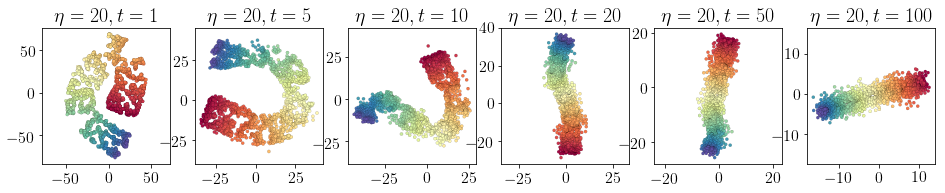

In [63]:
tsteps  = [1, 5, 10, 20, 50, 100]
embds = [scaled_difftsne_res['perp20_tstep' + str(tstep) + '_it0']['embedding'] 
         for tstep in tsteps]
names = [r"$\eta = 20, t = %d$" %tstep for tstep in tsteps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(16, 2.5), ncol = 6,
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

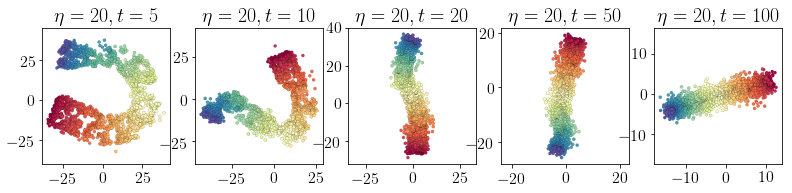

In [111]:
tsteps  = [5, 10, 20, 50, 100]
embds = [scaled_difftsne_res['perp20_tstep' + str(tstep) + '_it0']['embedding'] 
         for tstep in tsteps]
names = [r"$\eta = 20, t = %d$" %tstep for tstep in tsteps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(16, 2.5), ncol = 6,
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

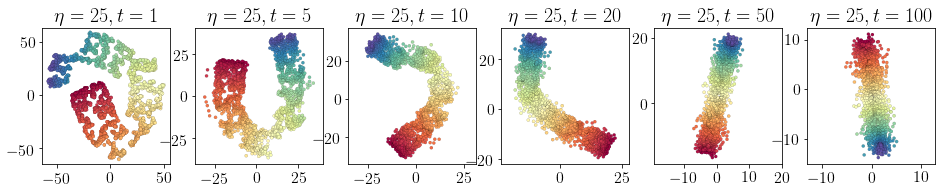

In [112]:
tsteps  = [1, 5, 10, 20, 50, 100]
embds = [scaled_difftsne_res['perp25_tstep' + str(tstep) + '_it0']['embedding'] 
         for tstep in tsteps]
names = [r"$\eta = 25, t = %d$" %tstep for tstep in tsteps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(16, 2.5), ncol = 6,
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

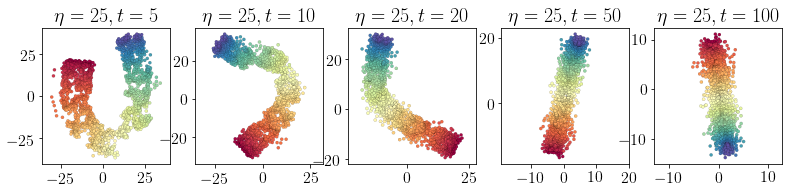

In [64]:
tsteps  = [5, 10, 20, 50, 100]
embds = [scaled_difftsne_res['perp25_tstep' + str(tstep) + '_it0']['embedding'] 
         for tstep in tsteps]
names = [r"$\eta = 25, t = %d$" %tstep for tstep in tsteps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(16, 2.5), ncol = 6,
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

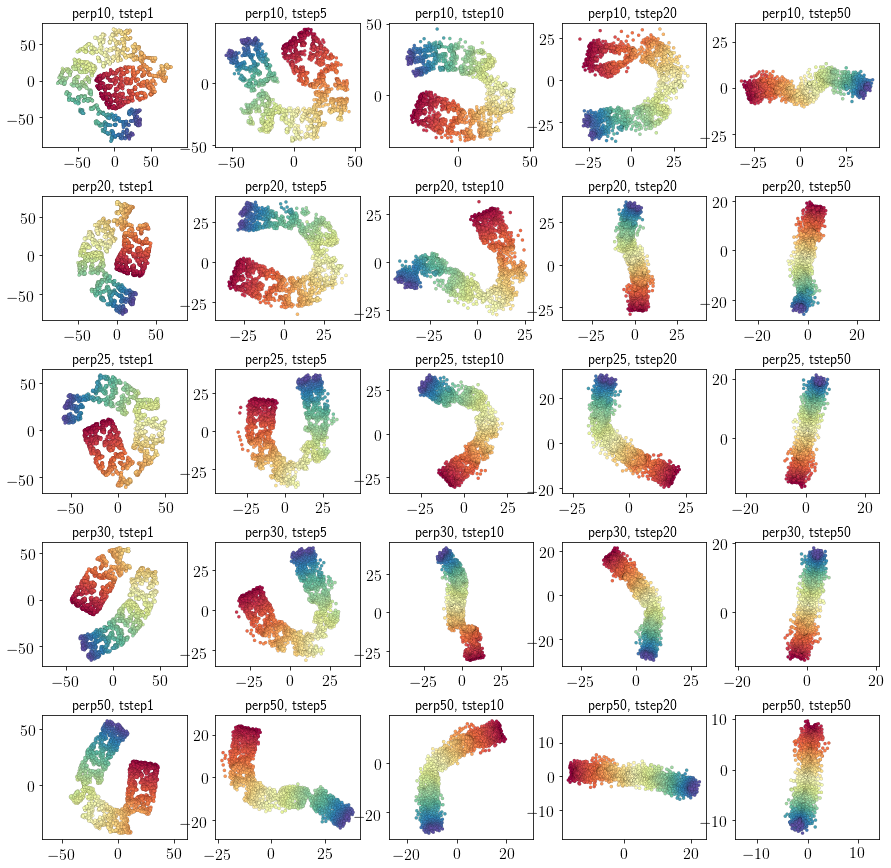

In [66]:
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50]
scaled_difftsne_embd, scaled_difftsne_time = get_res(
    scaled_difftsne_res, color, perps, 
    tsteps, figsize = (15, 15))
plt.subplots_adjust(hspace=0.4, wspace = 0.2)

In [67]:
# Performance
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50, 100]
keys = list(scaled_difftsne_embd.keys())
scaled_diff_tsne_spearman_mean = {}
scaled_diff_tsne_spearman_var = {}

keys = list(scaled_difftsne_embd.keys())
for perp in perps:
    for tstep in tsteps:
        comb = 'perp' + str(perp) + '_' + 'tstep' + str(tstep) + "_"
        cur_keys = [key for key in keys if comb in key]
        pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
        results = {}
        for key in cur_keys:
            Y = scaled_difftsne_embd[key]
            results[key] = pool.apply_async(geo_rho, args = (X, Y, GX))
        pool.close()
        pool.join()
        rho_mean_lst = [np.mean(res.get()) for name, res in results.items()]  # over data points
        rho_var_lst = [np.var(res.get()) for name, res in results.items()]
        scaled_diff_tsne_spearman_mean[comb] = rho_mean_lst
        scaled_diff_tsne_spearman_var[comb] = rho_var_lst

In [68]:
# Coranking matrix
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50, 100]
scaled_diff_tsne_corank = {}   
keys = list(scaled_difftsne_embd.keys())
for perp in perps:
    for tstep in tsteps:
        comb = 'perp' + str(perp) + '_' + 'tstep' + str(tstep) + "_"
        cur_keys = [key for key in keys if comb in key]
        pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
        results = {}
        for key in cur_keys:
            Y = scaled_difftsne_embd[key]
            results[key] = pool.apply_async(coranking_quality, 
                                            args = (Xtruth, Y, 'QNK', 1, 250))
        pool.close()
        pool.join()
        crank = { name: res.get() for name, res in results.items()}
        scaled_diff_tsne_corank[comb] = crank

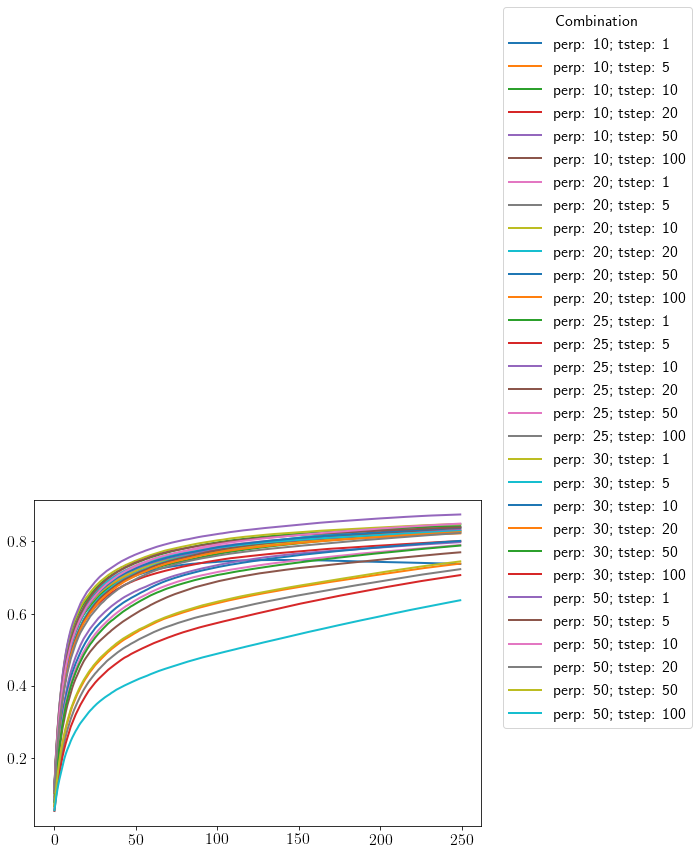

In [69]:
fig, ax = plt.subplots(figsize = (8, 6))
for perp in perps:
    for tstep in tsteps:
        comb = 'perp' + str(perp) + '_' + 'tstep' + str(tstep) + "_"
        comb_corank = scaled_diff_tsne_corank[comb]
        comb_corank = [ val for k, val in comb_corank.items()]
        comb_corank = np.array(comb_corank)
        mean_comb_corank = np.mean(comb_corank, axis = 0).ravel()
        n = mean_comb_corank.shape[0]
        line, = ax.plot(range(n), mean_comb_corank, linewidth=2, 
                        label= 'perp: ' + str(perp) + '; ' + 'tstep: ' + str(tstep))
ax.legend(loc=(250, 0), title='Combination', bbox_to_anchor= (1.05, 0.3))
plt.show()

In [70]:
# import pickle
# filename = 'examples/SwissRoll-noisy/scaled_diffusion_tsne/swiss_roll_scaled_diff_tsne.pkl'
# outfile = open(filename,'wb')
# obj_dict = {'X': X, 'color':color, 'y': y,
#             'scaled_difftsne_res':scaled_difftsne_res, 
#             'scaled_diff_tsne_spearman_mean':scaled_diff_tsne_spearman_mean,
#             'scaled_diff_tsne_spearman_var':scaled_diff_tsne_spearman_var,
#             'scaled_diff_tsne_corank':scaled_diff_tsne_corank
#            }
# pickle.dump(obj_dict, outfile)
# outfile.close()

In [ ]:
import pickle
filename = 'examples/SwissRoll-noisy/scaled_diffusion_tsne/swiss_roll_scaled_diff_tsne.pkl'
infile = open(filename,'rb')
new_dict = pickle.load(infile) 
infile.close()
locals().update(new_dict)

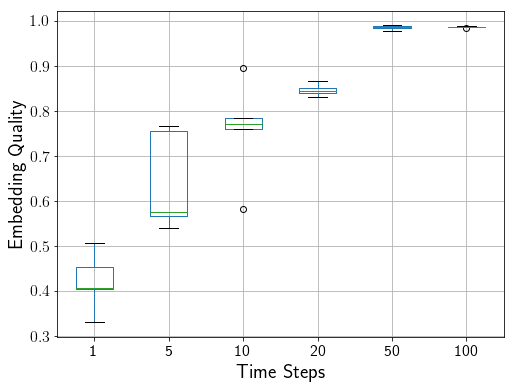

In [71]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp10_' in key]
df = pd.DataFrame(scaled_diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

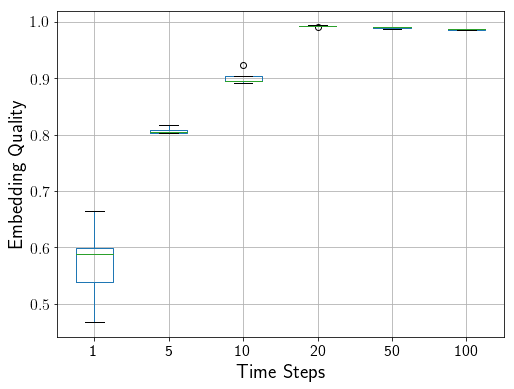

In [72]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp20_' in key]
df = pd.DataFrame(scaled_diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

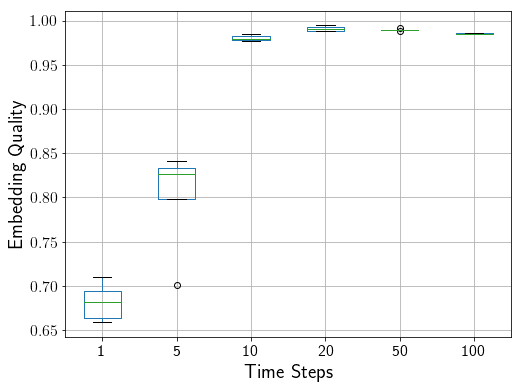

In [73]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp25_' in key]
df = pd.DataFrame(scaled_diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

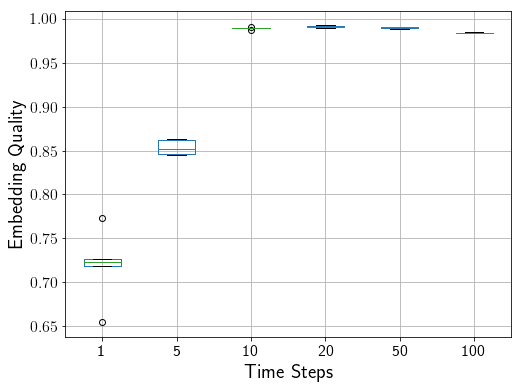

In [74]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp30_' in key]
df = pd.DataFrame(scaled_diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

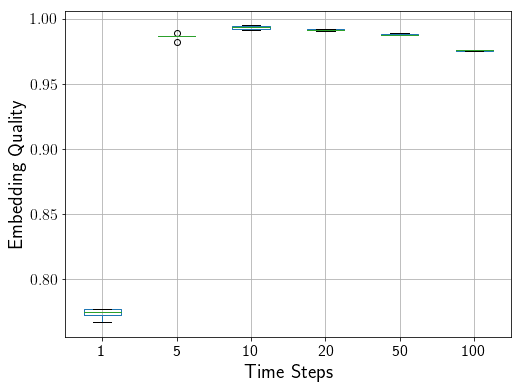

In [75]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp50_' in key]
df = pd.DataFrame(scaled_diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

## 2.4 UMAP

In [76]:
import umap
# in our implementation of FIt-SNE we use entropy = np.log(perplexity) whereas in
# umap one has entropy = np.log2(n_neigh) so we need to adjust:
# np.log(100) = np.log2(n_neigh) ==> n_neigh = 2**np.log(100)
# n_neigh [10-15] ==> perplexity [30-50]

def run_umap(X, nthreads, seed):
    start = time.time()
    Y = umap.UMAP(random_state = seed, transform_seed = seed).fit_transform(X)
    end = time.time()
    res = {'embedding' : Y, 'method' : 'umap', 'seed' : seed,
           'time' : end - start}
    return res

ncopies = 5
pool = mp.Pool(processes = min(ncopies, int(NCORES/nthreads), int(mp.cpu_count()/nthreads)))
results = {}
for i in range(ncopies):
    seed = np.random.randint(1, time.time(), size = 1)[0]
    trial = 'it' + str(i)
    try:
        results[trial] = pool.apply_async(
            run_umap, args = (X, nthreads, seed))
    except:
        results[trial] = {'embedding' : -1, 'time': -1}
pool.close()
pool.join()
umap_res = {name : result.get() for name, result in results.items()}

/home/lanhuong/.local/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


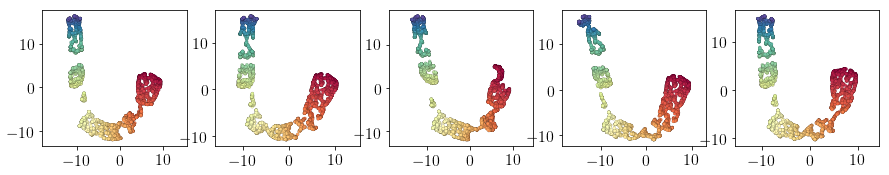

In [78]:
umap_embd_lst = [umap_res[key]['embedding'] for key in umap_res]
plot_embdeddings(umap_embd_lst, color, figsize=(15, 2.5), 
                s = 10, edgecolor='black', linewidth=0.1)

/home/lanhuong/.local/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


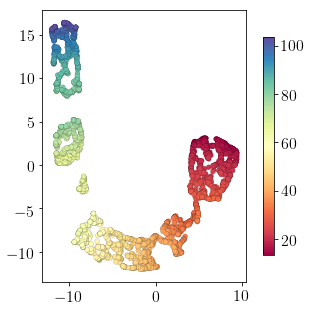

In [79]:
plot2D(umap_embd_lst[0], label=color, s=25, figsize=(6, 5))
plt.axes().set_aspect(1.0)

In [80]:
# Coranking matrix
umap_corank = {}
pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
for key in umap_res.keys():
    Y = umap_res[key]['embedding']
    umap_corank[key] = pool.apply_async(coranking_quality, args = (Xtruth, Y, 'QNK', 1, 250))
pool.close()
pool.join()
umap_corank = { name: res.get() for name, res in umap_corank.items()}

In [81]:
# Coranking matrix
pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
results= {}
for key in umap_res.keys():
    Y = umap_res[key]['embedding']
    results[key] = pool.apply_async(geo_rho, args = (X, Y, GX))
pool.close()
pool.join()

umap_spearman_mean = [np.mean(res.get()) for name, res in results.items()] 
umap_spearman_var = [np.var(res.get()) for name, res in results.items()] 

In [82]:
print("Mean and std of the average spearman rank correlation" + \
      " for UMAP is: %f +/- %f"
      %(np.mean(umap_spearman_mean),  np.std(umap_spearman_mean)))

Mean and std of the average spearman rank correlation for UMAP is: 0.895307 +/- 0.009812


In [83]:
umap_corank_df = pd.DataFrame(umap_corank)
umap_corank_df['mean'] = umap_corank_df.mean(axis = 1) 
umap_corank_df['sd'] = umap_corank_df.std(axis = 1) 
umap_corank_df.head()

it0       it1       it2       it3       it4      mean        sd
0  0.107703  0.111370  0.100033  0.109703  0.106369  0.107036  0.003894
1  0.190564  0.198566  0.188396  0.193565  0.194231  0.193064  0.003462
2  0.260754  0.263088  0.258308  0.259642  0.260198  0.260398  0.001571
3  0.323024  0.319190  0.318023  0.318023  0.317856  0.319223  0.001960
4  0.363321  0.361521  0.357386  0.360987  0.360387  0.360720  0.001934

<ErrorbarContainer object of 3 artists>

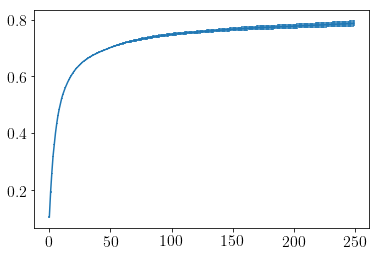

In [84]:
plt.errorbar(umap_corank_df.index, umap_corank_df['mean'], yerr=umap_corank_df['sd'])


# Plot Results

In [85]:
diff_tsne_corank['perp20_tstep1_'].keys()

dict_keys(['perp20_tstep1_it0', 'perp20_tstep1_it1', 'perp20_tstep1_it2', 'perp20_tstep1_it3', 'perp20_tstep1_it4'])

In [86]:
corank_df = pd.DataFrame(
    {
        'PCA':score_pca,
        'PHATE':score_phate,
        'ISOMAP':score_iso,
        'UMAP_mean': umap_corank_df['mean'],
        'UMAP_sd':umap_corank_df['sd'],
    }
)
chosen_perp = [25, 50, 100, 250]
chosen_tstep = [5, 10, 20, 50]

In [88]:
for perp in chosen_perp:
    if perp == 20:
        df = pd.DataFrame(diff_tsne_corank['perp20_tstep1_'])
    else:
        df = pd.DataFrame(vanilla_tsne_corank['perp'+str(perp)])
    corank_df['tSNE_perp' + str(perp) + '_mean']  = df.mean(axis = 1) 
    corank_df['tSNE_perp' + str(perp) + '_sd']  = df.std(axis = 1) 

In [89]:
for tstep in chosen_tstep:
    df = pd.DataFrame(diff_tsne_corank['perp25_tstep' + str(tstep) + "_"])
    corank_df['diff_tsne_corank' + str(tstep) + '_mean']  = df.mean(axis = 1) 
    corank_df['diff_tsne_corank' + str(tstep) + '_sd']  = df.std(axis = 1) 
    df = pd.DataFrame(scaled_diff_tsne_corank['perp25_tstep' + str(tstep) + "_"])
    corank_df['scaled_diff_tsne_corank' + str(tstep) + '_mean']  = df.mean(axis = 1) 
    corank_df['scaled_diff_tsne_corank' + str(tstep) + '_sd']  = df.std(axis = 1) 
corank_df0 = corank_df

In [90]:
corank_df.head()

PCA     PHATE    ISOMAP  UMAP_mean   UMAP_sd  tSNE_perp25_mean  \
0  0.063021  0.306435  0.117372   0.107036  0.003894          0.123174   
1  0.084028  0.403801  0.205735   0.193064  0.003462          0.213404   
2  0.101478  0.473602  0.268534   0.260398  0.001571          0.279071   
3  0.113038  0.518089  0.322774   0.319223  0.001960          0.340297   
4  0.124575  0.535845  0.363188   0.360720  0.001934          0.383835   

   tSNE_perp25_sd  tSNE_perp50_mean  tSNE_perp50_sd  tSNE_perp100_mean  \
0        0.001677          0.125242        0.001627           0.124041   
1        0.000817          0.216972        0.001562           0.217506   
2        0.000552          0.284450        0.000870           0.285918   
3        0.000960          0.344798        0.000397           0.344882   
4        0.000456          0.388236        0.000934           0.390690   

               ...               scaled_diff_tsne_corank10_mean  \
0              ...                                     0.108103   
1              ...                                     0.194198   
2              ...                                     0.255441   
3              ...                                     0.311604   
4              ...                                     0.351384   

   scaled_diff_tsne_corank10_sd  diff_tsne_corank20_mean  \
0                      0.000548                 0.106702   
1                      0.003082                 0.191897   
2                      0.002492                 0.253685   
3                      0.002943                 0.309436   
4                      0.002089                 0.348329   

   diff_tsne_corank20_sd  scaled_diff_tsne_corank20_mean  \
0               0.003318                        0.103168   
1               0.002151                        0.185529   
2               0.002831                        0.245971   
3               0.001870                        0.297082   
4               0.003016                        0.334525   

   scaled_diff_tsne_corank20_sd  diff_tsne_corank50_mean  \
0                      0.002653                 0.090830   
1                      0.002067                 0.163788   
2                      0.001624                 0.221985   
3                      0.002676                 0.273091   
4                      0.001859                 0.309263   

   diff_tsne_corank50_sd  scaled_diff_tsne_corank50_mean  \
0               0.000691                        0.081294   
1               0.003193                        0.143348   
2               0.005218                        0.195198   
3               0.005821                        0.239980   
4               0.005922                        0.272477   

   scaled_diff_tsne_corank50_sd  
0                      0.002242  
1                      0.000361  
2                      0.002519  
3                      0.002931  
4                      0.003668  

[5 rows x 29 columns]

In [91]:
#corank_df = corank_df.iloc[0:50, :]
corank_df =corank_df0

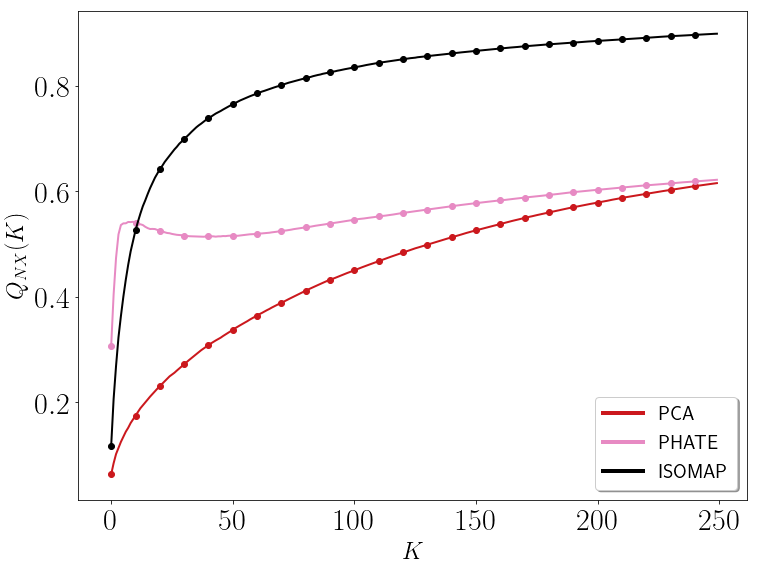

In [92]:
df2plot = corank_df.iloc[::10, :]
tsne_cols = ["#A1D99B" , "#41AB5D" ,"#238B45" ,"#00441B"]
difftsne_colors = ["#FDAE6B", "#F16913", "#D94801", "#7F2704" ]
scaled_diff_tsne_colors = ["#BCBDDC",  "#807DBA" ,"#54278F", "#3F007D"]
mpl.rcParams['xtick.labelsize']  = 30
mpl.rcParams['ytick.labelsize']  = 30


plt.figure(figsize = (12, 9))

plt.scatter(df2plot.index, df2plot['PCA'], marker = 'o', label ='', c = "#CB181D")
plt.scatter(df2plot.index, df2plot['PHATE'], marker='o', label = '', c="#E78AC3" )
plt.plot(corank_df.index, corank_df['PCA'], label ='PCA', c = "#CB181D",  linewidth = 2)
plt.plot(corank_df.index, corank_df['PHATE'],  label = 'PHATE', c="#E78AC3",  linewidth = 2)

plt.scatter(df2plot.index, df2plot['ISOMAP'], marker='o', label = '', c="black" )
plt.plot(corank_df.index, corank_df['ISOMAP'],  label = 'ISOMAP', c="black",  linewidth = 2 )

leg = plt.legend(
    fontsize=20, markerscale=1, 
    #loc='upper center', bbox_to_anchor=(1.3, 1.0), 
    shadow=True, ncol=1)

for line in leg.get_lines():
    line.set_linewidth(4.0)

plt.xlabel(r"$K$", fontsize=24)
plt.ylabel(r"$Q_{NX}(K)$", fontsize=24)

mpl.rcParams['xtick.labelsize']  = 16
mpl.rcParams['ytick.labelsize']  = 16

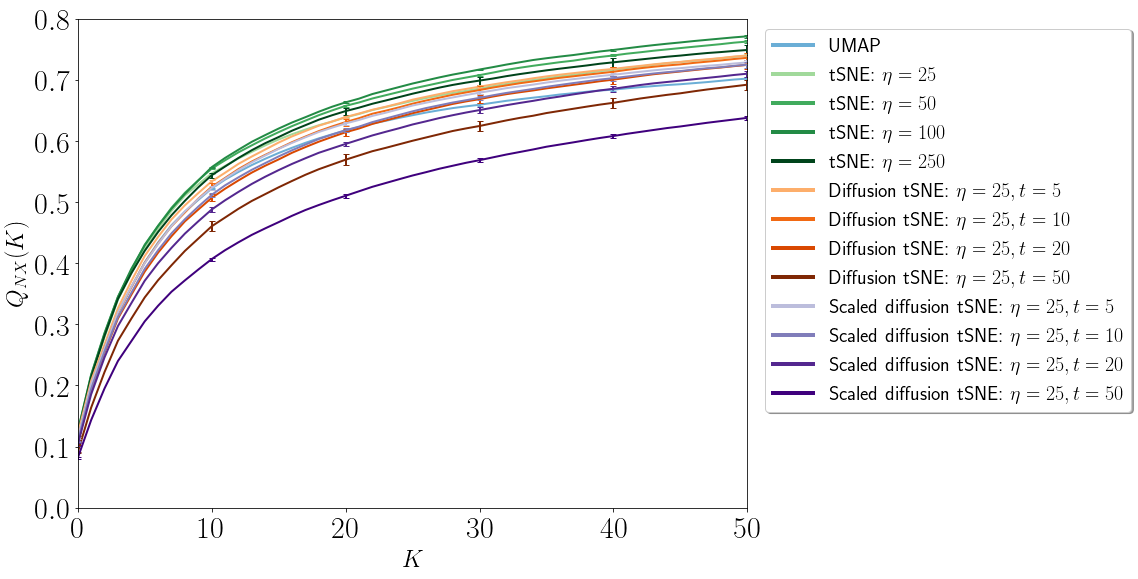

In [119]:
df2plot = corank_df.iloc[::10, :]
tsne_cols = ["#A1D99B" , "#41AB5D" ,"#238B45" ,"#00441B"]
difftsne_colors = ["#FDAE6B", "#F16913", "#D94801", "#7F2704" ]
scaled_diff_tsne_colors = ["#BCBDDC",  "#807DBA" ,"#54278F", "#3F007D"]
mpl.rcParams['xtick.labelsize']  = 30
mpl.rcParams['ytick.labelsize']  = 30


plt.figure(figsize = (12, 9))

# plt.scatter(df2plot.index, df2plot['PCA'], marker = 'o', label ='', c = "#CB181D")
# plt.scatter(df2plot.index, df2plot['PHATE'], marker='o', label = '', c="#E78AC3" )
# plt.plot(corank_df.index, corank_df['PCA'], label ='PCA', c = "#CB181D",  linewidth = 2)
# plt.plot(corank_df.index, corank_df['PHATE'],  label = 'PHATE', c="#E78AC3",  linewidth = 2)

# plt.scatter(df2plot.index, df2plot['ISOMAP'], marker='o', label = '', c="black" )
# plt.plot(corank_df.index, corank_df['ISOMAP'],  label = 'ISOMAP', c="black",  linewidth = 2 )

plt.plot(corank_df.index, corank_df['UMAP_mean'], 
         linewidth = 2, label ='UMAP', c =  "#6BAED6")
plt.errorbar(df2plot.index, df2plot['UMAP_mean'], yerr=df2plot['UMAP_sd'], 
             linewidth =0, elinewidth=2, label = '', c =  "#6BAED6", capsize=3)
for i, perp in enumerate(chosen_perp):
    plt.plot(corank_df.index, corank_df['tSNE_perp'+ str(perp) + '_mean'],
             label =r'tSNE: $\eta=%d$' %perp, c = tsne_cols[i], linewidth=2)
    plt.errorbar(df2plot.index, df2plot['tSNE_perp'+ str(perp) + '_mean'], 
                 yerr=df2plot['tSNE_perp'+ str(perp) +'_sd'], capsize=3,
                 linewidth =0, elinewidth=2, label = '', c = tsne_cols[i])
    
for i, tstep in enumerate(chosen_tstep):
    plt.plot(corank_df.index, corank_df['diff_tsne_corank'+ str(tstep) + '_mean'],
             label =r'Diffusion tSNE: $\eta=25, t=%d$' %tstep, c = difftsne_colors[i],
            linewidth=2)
    plt.errorbar(df2plot.index, df2plot['diff_tsne_corank'+ str(tstep) + '_mean'], 
                 yerr=df2plot['diff_tsne_corank'+ str(tstep) +'_sd'], capsize=3,
                 linewidth =0, elinewidth=2, label = '', c = difftsne_colors[i])
    
for i, tstep in enumerate(chosen_tstep):
    plt.plot(corank_df.index, corank_df['scaled_diff_tsne_corank'+ str(tstep) + '_mean'],
             label =r'Scaled diffusion tSNE: $\eta=25, t=%d$' %tstep, 
             c = scaled_diff_tsne_colors[i], linewidth=2)
    plt.errorbar(df2plot.index, df2plot['scaled_diff_tsne_corank'+ str(tstep) + '_mean'], 
                 yerr=df2plot['scaled_diff_tsne_corank'+ str(tstep) +'_sd'], capsize=3,
                 linewidth =0, elinewidth=2, label = '', c = scaled_diff_tsne_colors[i])

leg = plt.legend(
    fontsize=20, markerscale=1, 
    loc='upper center', bbox_to_anchor=(1.3, 1.0), 
    shadow=True, ncol=1)

for line in leg.get_lines():
    line.set_linewidth(4.0)

plt.xlabel(r"$K$", fontsize=24)
plt.ylabel(r"$Q_{NX}(K)$", fontsize=24)
plt.xlim(0, 50)
plt.ylim(0, 0.8)

mpl.rcParams['xtick.labelsize']  = 16
mpl.rcParams['ytick.labelsize']  = 16

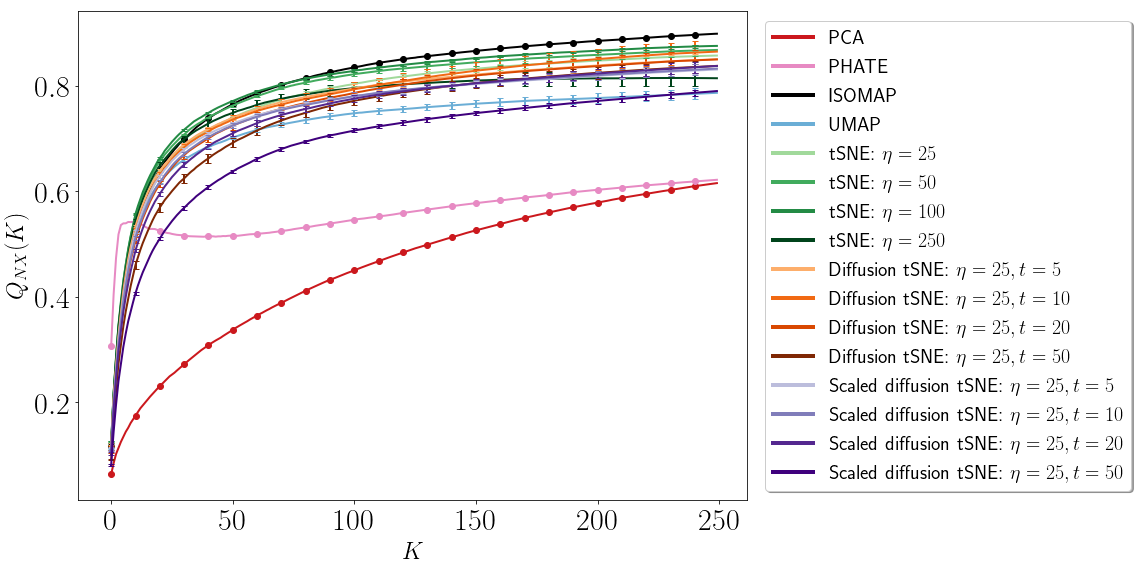

In [114]:
df2plot = corank_df.iloc[::10, :]
tsne_cols = ["#A1D99B" , "#41AB5D" ,"#238B45" ,"#00441B"]
difftsne_colors = ["#FDAE6B", "#F16913", "#D94801", "#7F2704" ]
scaled_diff_tsne_colors = ["#BCBDDC",  "#807DBA" ,"#54278F", "#3F007D"]
mpl.rcParams['xtick.labelsize']  = 30
mpl.rcParams['ytick.labelsize']  = 30


plt.figure(figsize = (12, 9))

plt.scatter(df2plot.index, df2plot['PCA'], marker = 'o', label ='', c = "#CB181D")
plt.scatter(df2plot.index, df2plot['PHATE'], marker='o', label = '', c="#E78AC3" )
plt.plot(corank_df.index, corank_df['PCA'], label ='PCA', c = "#CB181D",  linewidth = 2)
plt.plot(corank_df.index, corank_df['PHATE'],  label = 'PHATE', c="#E78AC3",  linewidth = 2)

plt.scatter(df2plot.index, df2plot['ISOMAP'], marker='o', label = '', c="black" )
plt.plot(corank_df.index, corank_df['ISOMAP'],  label = 'ISOMAP', c="black",  linewidth = 2 )

plt.plot(corank_df.index, corank_df['UMAP_mean'], 
         linewidth = 2, label ='UMAP', c =  "#6BAED6")
plt.errorbar(df2plot.index, df2plot['UMAP_mean'], yerr=df2plot['UMAP_sd'], 
             linewidth =0, elinewidth=2, label = '', c =  "#6BAED6", capsize=3)
for i, perp in enumerate(chosen_perp):
    plt.plot(corank_df.index, corank_df['tSNE_perp'+ str(perp) + '_mean'],
             label =r'tSNE: $\eta=%d$' %perp, c = tsne_cols[i], linewidth=2)
    plt.errorbar(df2plot.index, df2plot['tSNE_perp'+ str(perp) + '_mean'], 
                 yerr=df2plot['tSNE_perp'+ str(perp) +'_sd'], capsize=3,
                 linewidth =0, elinewidth=2, label = '', c = tsne_cols[i])
    
for i, tstep in enumerate(chosen_tstep):
    plt.plot(corank_df.index, corank_df['diff_tsne_corank'+ str(tstep) + '_mean'],
             label =r'Diffusion tSNE: $\eta=25, t=%d$' %tstep, c = difftsne_colors[i],
            linewidth=2)
    plt.errorbar(df2plot.index, df2plot['diff_tsne_corank'+ str(tstep) + '_mean'], 
                 yerr=df2plot['diff_tsne_corank'+ str(tstep) +'_sd'], capsize=3,
                 linewidth =0, elinewidth=2, label = '', c = difftsne_colors[i])
    
for i, tstep in enumerate(chosen_tstep):
    plt.plot(corank_df.index, corank_df['scaled_diff_tsne_corank'+ str(tstep) + '_mean'],
             label =r'Scaled diffusion tSNE: $\eta=25, t=%d$' %tstep, 
             c = scaled_diff_tsne_colors[i], linewidth=2)
    plt.errorbar(df2plot.index, df2plot['scaled_diff_tsne_corank'+ str(tstep) + '_mean'], 
                 yerr=df2plot['scaled_diff_tsne_corank'+ str(tstep) +'_sd'], capsize=3,
                 linewidth =0, elinewidth=2, label = '', c = scaled_diff_tsne_colors[i])

leg = plt.legend(
    fontsize=20, markerscale=1, 
    loc='upper center', bbox_to_anchor=(1.3, 1.0), 
    shadow=True, ncol=1)

for line in leg.get_lines():
    line.set_linewidth(4.0)

plt.xlabel(r"$K$", fontsize=24)
plt.ylabel(r"$Q_{NX}(K)$", fontsize=24)

mpl.rcParams['xtick.labelsize']  = 16
mpl.rcParams['ytick.labelsize']  = 16

# Spearman Correlations

In [94]:
for perp in [10, 20, 25, 50, 100, 250, 300, 500]:
    if perp == 20:
        rho = diff_tsne_spearman_mean['perp20_tstep1_']
    else:
        rho = vanilla_tsne_spearman_mean['perp'+ str(perp)]
    print("Mean and std of the average spearman rank correlation" + \
          " for vanilla t-SNE at perp %d is: %.3f \; (%.4f)"
          %(perp, np.mean(rho),  np.std(rho)))

Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 10 is: 0.610 \; (0.0831)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 20 is: 0.696 \; (0.0566)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 25 is: 0.703 \; (0.0734)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 50 is: 0.866 \; (0.0392)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 100 is: 0.854 \; (0.0049)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 250 is: 0.472 \; (0.0137)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 300 is: 0.442 \; (0.0065)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 500 is: 0.394 \; (0.0202)


In [95]:
perp = 10
for tstep in tsteps:
    rho = diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 1is: 0.642 (0.0557)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 5is: 0.811 (0.0157)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 10is: 0.827 (0.0072)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 20is: 0.908 (0.0225)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 50is: 0.987 (0.0029)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 100is: 0.987 (0.0011)


In [96]:
perp = 20
for tstep in tsteps:
    rho = diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 1is: 0.696 \; (0.0566)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 5is: 0.909 \; (0.0414)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 10is: 0.966 \; (0.0089)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 20is: 0.989 \; (0.0018)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 50is: 0.990 \; (0.0017)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 100is: 0.988 \; (0.0002)


In [97]:
perp = 25
for tstep in tsteps:
    rho = diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.4f\; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 1is: 0.6949\; (0.1055)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 5is: 0.8867\; (0.0065)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 10is: 0.9903\; (0.0032)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 20is: 0.9891\; (0.0036)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 50is: 0.9898\; (0.0012)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 100is: 0.9857\; (0.0008)


In [98]:
perp = 30
for tstep in tsteps:
    rho = diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 1is: 0.795 \; (0.0446)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 5is: 0.943 \; (0.0180)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 10is: 0.990 \; (0.0023)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 20is: 0.986 \; (0.0010)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 50is: 0.988 \; (0.0017)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 100is: 0.984 \; (0.0007)


In [99]:
perp = 50
for tstep in tsteps:
    rho = diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 1is: 0.777 \; (0.1269)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 5is: 0.986 \; (0.0052)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 10is: 0.991 \; (0.0021)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 20is: 0.990 \; (0.0015)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 50is: 0.987 \; (0.0007)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 100is: 0.979 \; (0.0005)


In [100]:
perp = 10
for tstep in tsteps:
    rho = scaled_diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 1is: 0.421 \; (0.0584)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 5is: 0.641 \; (0.0992)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 10is: 0.759 \; (0.1009)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 20is: 0.847 \; (0.0116)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 50is: 0.986 \; (0.0040)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 100is: 0.987 \; (0.0016)


In [101]:
perp = 20
for tstep in tsteps:
    rho = scaled_diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 1is: 0.572 \; (0.0657)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 5is: 0.807 \; (0.0052)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 10is: 0.903 \; (0.0120)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 20is: 0.993 \; (0.0010)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 50is: 0.990 \; (0.0016)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 100is: 0.987 \; (0.0004)


In [102]:
perp = 25
for tstep in tsteps:
    rho = scaled_diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 1is: 0.682 \; (0.0189)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 5is: 0.800 \; (0.0515)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 10is: 0.980 \; (0.0028)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 20is: 0.991 \; (0.0024)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 50is: 0.990 \; (0.0009)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 100is: 0.986 \; (0.0005)


In [103]:
perp = 30
for tstep in tsteps:
    rho = scaled_diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 1is: 0.719 \; (0.0379)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 5is: 0.854 \; (0.0079)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 10is: 0.990 \; (0.0010)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 20is: 0.991 \; (0.0008)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 50is: 0.990 \; (0.0008)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 100is: 0.984 \; (0.0004)


In [104]:
perp = 50
for tstep in tsteps:
    rho = scaled_diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 1is: 0.773 \; (0.0036)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 5is: 0.986 \; (0.0023)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 10is: 0.993 \; (0.0015)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 20is: 0.991 \; (0.0005)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 50is: 0.988 \; (0.0006)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 100is: 0.976 \; (0.0004)
